## Notes and ideas :
- look for the frequency of publication of articles.
#### Features to be included in the template:
- Images with more weighting than the body of the article ( they may contain more information and impact on the reader).
- Measure the degree of objectivity or subjectivity (using the Vader metric) of bbc news writers by calculating the average distance of a bbc article from neutralitypoint (this could be done by applying the prediction model on more various categories -hence more data injected) , input this into your main model.
- Count the number of authors and see if studying each author separately is efficient, knowing that no much writters write in the climate rubrique.
- A picture (if subjective) is worth a thousand words", but if it is not significant, i.e. objective, it has no impact, no matter how much we consider it, the final result will not be affected. so we multiply the picture text (not a thousand times ofc hhh) to ponder with the rest of the article content.
- study the sentiment of news about some emerging notion : metaverse (in cathefories and NER) maybe something else.
## Insight :
- Transfer learning is already applied, make sure in the insight that you offer a path to relearn the Vader program to articles similar to bbc news.  

In [2]:
import os
import csv
import json
import nltk
import time
import spacy 
import shutil
import logging
import requests
import matplotlib
import numpy as np
import random as rd
import pandas as pd
import urllib.request
from PIL import Image
import networkx as nx
from spacy import displacy
from tqdm.notebook import *
import plotly.express as px
from bs4 import BeautifulSoup
from itertools import groupby
from spacy.tokens import Span 
from selenium import webdriver
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from spacy.matcher import Matcher 
nlp = spacy.load("en_core_web_sm")
from urllib.request import urlopen
from typing import List, Tuple, Dict
from matplotlib.pyplot import figure
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from stanfordcorenlp import StanfordCoreNLP
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options as FirefoxOptions

# I- Fetching data :

Used to fetch news data using an original scrapper, so they be injected into the model as additional features  

In [2]:
def scrap_one_article(url, _, nbr_articles) -> Dict:
    
    #Function that scrapps one article's data and zipps it into a dictionary 
    url_clean = url
    if url[6:19] == url[26:39]:
        url_clean = url[19:]
        print(url_clean)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    author = 'BBC News'
    title = None
    
    #Certain articles do miss some elements, they are rare. 
    try:
        author = soup.find_all(class_ = 'ssrcss-1rv0moy-Contributor')[0].find('strong').text[3:]
    except:
        pass
    try:
        title = soup.find_all(class_ = 'ssrcss-gcq6xq-StyledHeading')[0].text
    except: 
        pass
    try:
        date = soup.find_all(class_ = 'ecn1o5v2')[0].find('time')['datetime'][:10]
    except: 
        date = None
    try:
        cathegory = soup.find_all(class_ = 'ed0g1kj0')[0].text
    except: 
        cathegory = 'General'
    Content_list = soup.find_all(class_ = 'eq5iqo00')
    article_content = build_text(Content_list)
    try:
        article_content = article_content.strip('There\'s something for everyone on iPlayer\nIncluding Frozen, Moana, Worzel Gummidge and more...','')
        article_content = article_content.strip('If you are reading this page and can\'t see the form you will need to visit the mobile version of the BBC website to submit your question or comment or you can email us at HaveYourSay@bbc.co.uk. Please include your name, age and location with any submission','')
    except:
        pass
    if article_content[:28] == 'This video can not be played':
        article_content = article_content[29:]
    Images_descriptions = download_images_description(soup)    
    article_dic= {'url': url_clean,'author':author,'date': date,'cathegory':cathegory,'title':title,'article_content':article_content, 'Image count': len(Images_descriptions), 'images descriptions':Images_descriptions}
    return article_dic

In [3]:
#tools
def build_text(list_) -> str:
    
    #building a text from a list 
    list_.pop()
    return '\n'.join([x.text for x in list_])
def dl_img(url, file_path, file_name) -> str:
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    return full_path
def download_images(soup_result,article_index,nbr_articles) -> int:
    
    #Downloading images from a links lists, then storing them locally ( within the server if it was hosted )
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['src'] for res in soup_result.find_all('img')][-12:]
    print(len(img_results))
    for _ in tqdm (range(1,len(img_results))):
        image_link = img_results[_]
        image_link_loc = f'images/Article{article_index}/'
        file_name = f'img{_}'
        try:
            image_link_local = dl_img(image_link,image_link_loc, file_name)
            i += 1
            nbr_img+=1
        except:
            pass
        return nbr_img
def download_images_description(soup_result) -> List:
    
    #Downloading description of images.
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['alt'] for res in soup_result.find_all('img')][-12:]
    img_results
    return img_results

In [ ]:
options = FirefoxOptions()
#options.add_argument("--headless")
driver = webdriver.Firefox(options=options)
driver.get("https://www.bbc.com/news/science-environment-56837908")
links = []
def get_links_list(driver,page) -> List[str]:
        
    '''Fetch all of the article's links from the BBC Climate url
       Selinium is used as well to scroll the News Updates pages'''
    if page > 49:
        return links
    else:
        while True:
            try:
                if driver.find_elements(By.CLASS_NAME,'qa-heading-link') != None:
                    for _ in driver.find_elements(By.CLASS_NAME,'qa-heading-link') :
                        links.append(_.get_attribute('href'))
                    break
            except:
                pass
        try:
                WebDriverWait(driver, 2500).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".qa-pagination-next-page[rel='next']"))).click()
        except:
                get_links_list(driver, page+2)
        page = page+1
        return get_links_list(driver, page+1)
def get_links_update(url = 'https://www.bbc.com/news/science-environment-56837908'):
    
    #fetch latest articles links via beautiful soup
    url = 'https://www.bbc.com/news/science-environment-56837908'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    results = soup.find_all('a',class_ = 'qa-heading-link')
    links_list = ['http://www.bbc.com/'+res['href'] if (res['href'][6:19] != res['href'][26:39]) else res['href'] for res in results]
    return links_list
all_links = get_links_list(driver,0)
len(all_links)

In [ ]:
#A tool function to scrap a category from links
def scrap_bbc_articles(links,category_url = 'https://www.bbc.com/news/science-environment-56837908') -> List[Dict]:
    
    # Scrap all of the articles
    url = category_url
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    print('Request status (200 means a succesful request): ',response.status_code)
    print('fetching begun ...')
    print('Fetching data from ',len(links) - 5 ,' bbc news articles')
    results = []
    print('------------------------------------')
    for _ in tqdm(range(0,len(links)-5), desc = 'Fetching articles'):  # Covers all the articles len(links)+1
        try: 
            A = scrap_one_article(links[_], _, len(links))
            results.append(A)
        except:
            _ = _ +1
    return results

In [ ]:
# A fúnction used to scrap and zip articles information from a list of links
def scrap(links) -> List[Dict]:
    climate_url = 'https://www.bbc.com/news/science-environment-56837908'
    data = scrap_bbc_articles(links)
    # fetching data from articles
    article_results = [] 
    for i in range(len(data)):
        try:
                article_dict = {}
                article_dict['cathegory'] = data[i]['cathegory']
                article_dict['author'] = data[i]['author']
                article_dict['title'] = data[i]['title']
                article_dict['Publish date'] = data[i]['date']
                article_dict['url'] = data[i]['url']
                article_dict['article_content'] = data[i]['article_content'].strip("\n").strip("\t")
                article_dict['images descriptions'] = data[i]['images descriptions']
                article_results.append(article_dict)
        except IndexError:
                pass
    return article_results

In [ ]:
def scrap_all():
    print('updating Data ...')
    # a function to update the articles Data Base
    url = 'https://www.bbc.com/news/science-environment-56837908'
    data = pd.DataFrame.from_dict(scrap(scrap_bbc_articles(get_links_list(driver,0)),get_links_list(driver,0)))
    print('Size of data : ', len(data))
    return data

In [ ]:
pd.set_option('max_colwidth', 500)
pd.set_option('max_colwidth', 60)
def update_scrap():
    # Recover data from backup file
    Data = pd.read_excel('exported_bbc_data-labelised.xlsx')
    Data.to_csv('exported_bbc_data-labelised.csv')
    Data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')
    print('updating Data ...')
    # a function to update the articles Data Base
    url = 'https://www.bbc.com/news/science-environment-56837908'
    data = pd.DataFrame.from_dict(scrap(all_links))
    print('Size of data : ', len(Data))
    scrap_bbc_articles
    Data  = data.append(Data)
    return Data
Data = scrap_all()
Data.head()

In [ ]:
Data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')


<h1> II- Data preprocessing :</h1>

### 2.1 Introduction
Feature engineering is an important process in the pipeline of any machine learning project.
It involves applying a series of transformations to the data, including
data.
The motivation behind this process is to feed the algorithms with digested data
and to improve their performance by reducing the learning time.
In this project, different data processing techniques were applied to implement the NLP.

In [ ]:
Data.columns

In [ ]:
def clean(Data,sentiment):
    useful_columns = ['cathegory', 'author', 'title', 'Publish date', 'article_content', 'images descriptions', 'sentiment' if sentiment == True else None, 'NE summaries' ]
    for column in Data.columns:
        try:
            if not(column in useful_columns):
                Data = Data.drop(column, axis = 1) 
        except:
            pass
    Data["Publish date"].fillna( method ='ffill', inplace = True) # Fill NaN values
    Data["title"].fillna('Title of article', inplace = True) # won't be used anyways
    return Data

Data = clean(Data,sentiment = False)
Data.to_csv('exported_bbc_data-labelised.csv')
Data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')

Data.iloc[:20]

### 2.3 NER : Named entities recognition :
Named entity recognition is a subtask of the activity of information extraction in documentary corpora. It consists of searching for textual objects (i.e. a word, or a group of words) that can be categorised in classes such as names of people, names of organisations or companies, names of places, quantities, distances, values, dates, etc.
As it is part of the task, we are asked to display sentiment analysis for each NER.
the aim of this sub-section is to try different Nlp models to get the list of named entities from text. the summaries of phrases in which they figured, as well as a google search for each entity, then store in the main output csv file.

In [11]:
index = 7
str_ = str(Data.iloc[index]['article_content']) # Article sample
str_[:200]

"California's giant sequoias are symbols of permanence - with some living for thousands of years. But the fierce wildfires ravaging the state threaten even these mighty trees, which are among the longe"


#### 2.3.1 Spacy :

SpaCy is a Python software library for automatic language processing developed by Matt Honnibal and Ines Montani. SpaCy is open source software released under the MIT license. The SpaCy library can perform the following analysis operations on texts in over 50 languages : 
- Tokenization 
- NER


In [21]:
def get_Ner(str_) -> List[pd.DataFrame]:
    #using spacy to recognise named entites
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(str_)
    entities = []
    labels = []
    position_start = []
    position_end = []
    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)
    data_entities_2 = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
    persons_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'PERSON')]
    country_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'GPE')]
    org_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'ORG')]
    return [data_entities_2,persons_df,country_df, org_df]

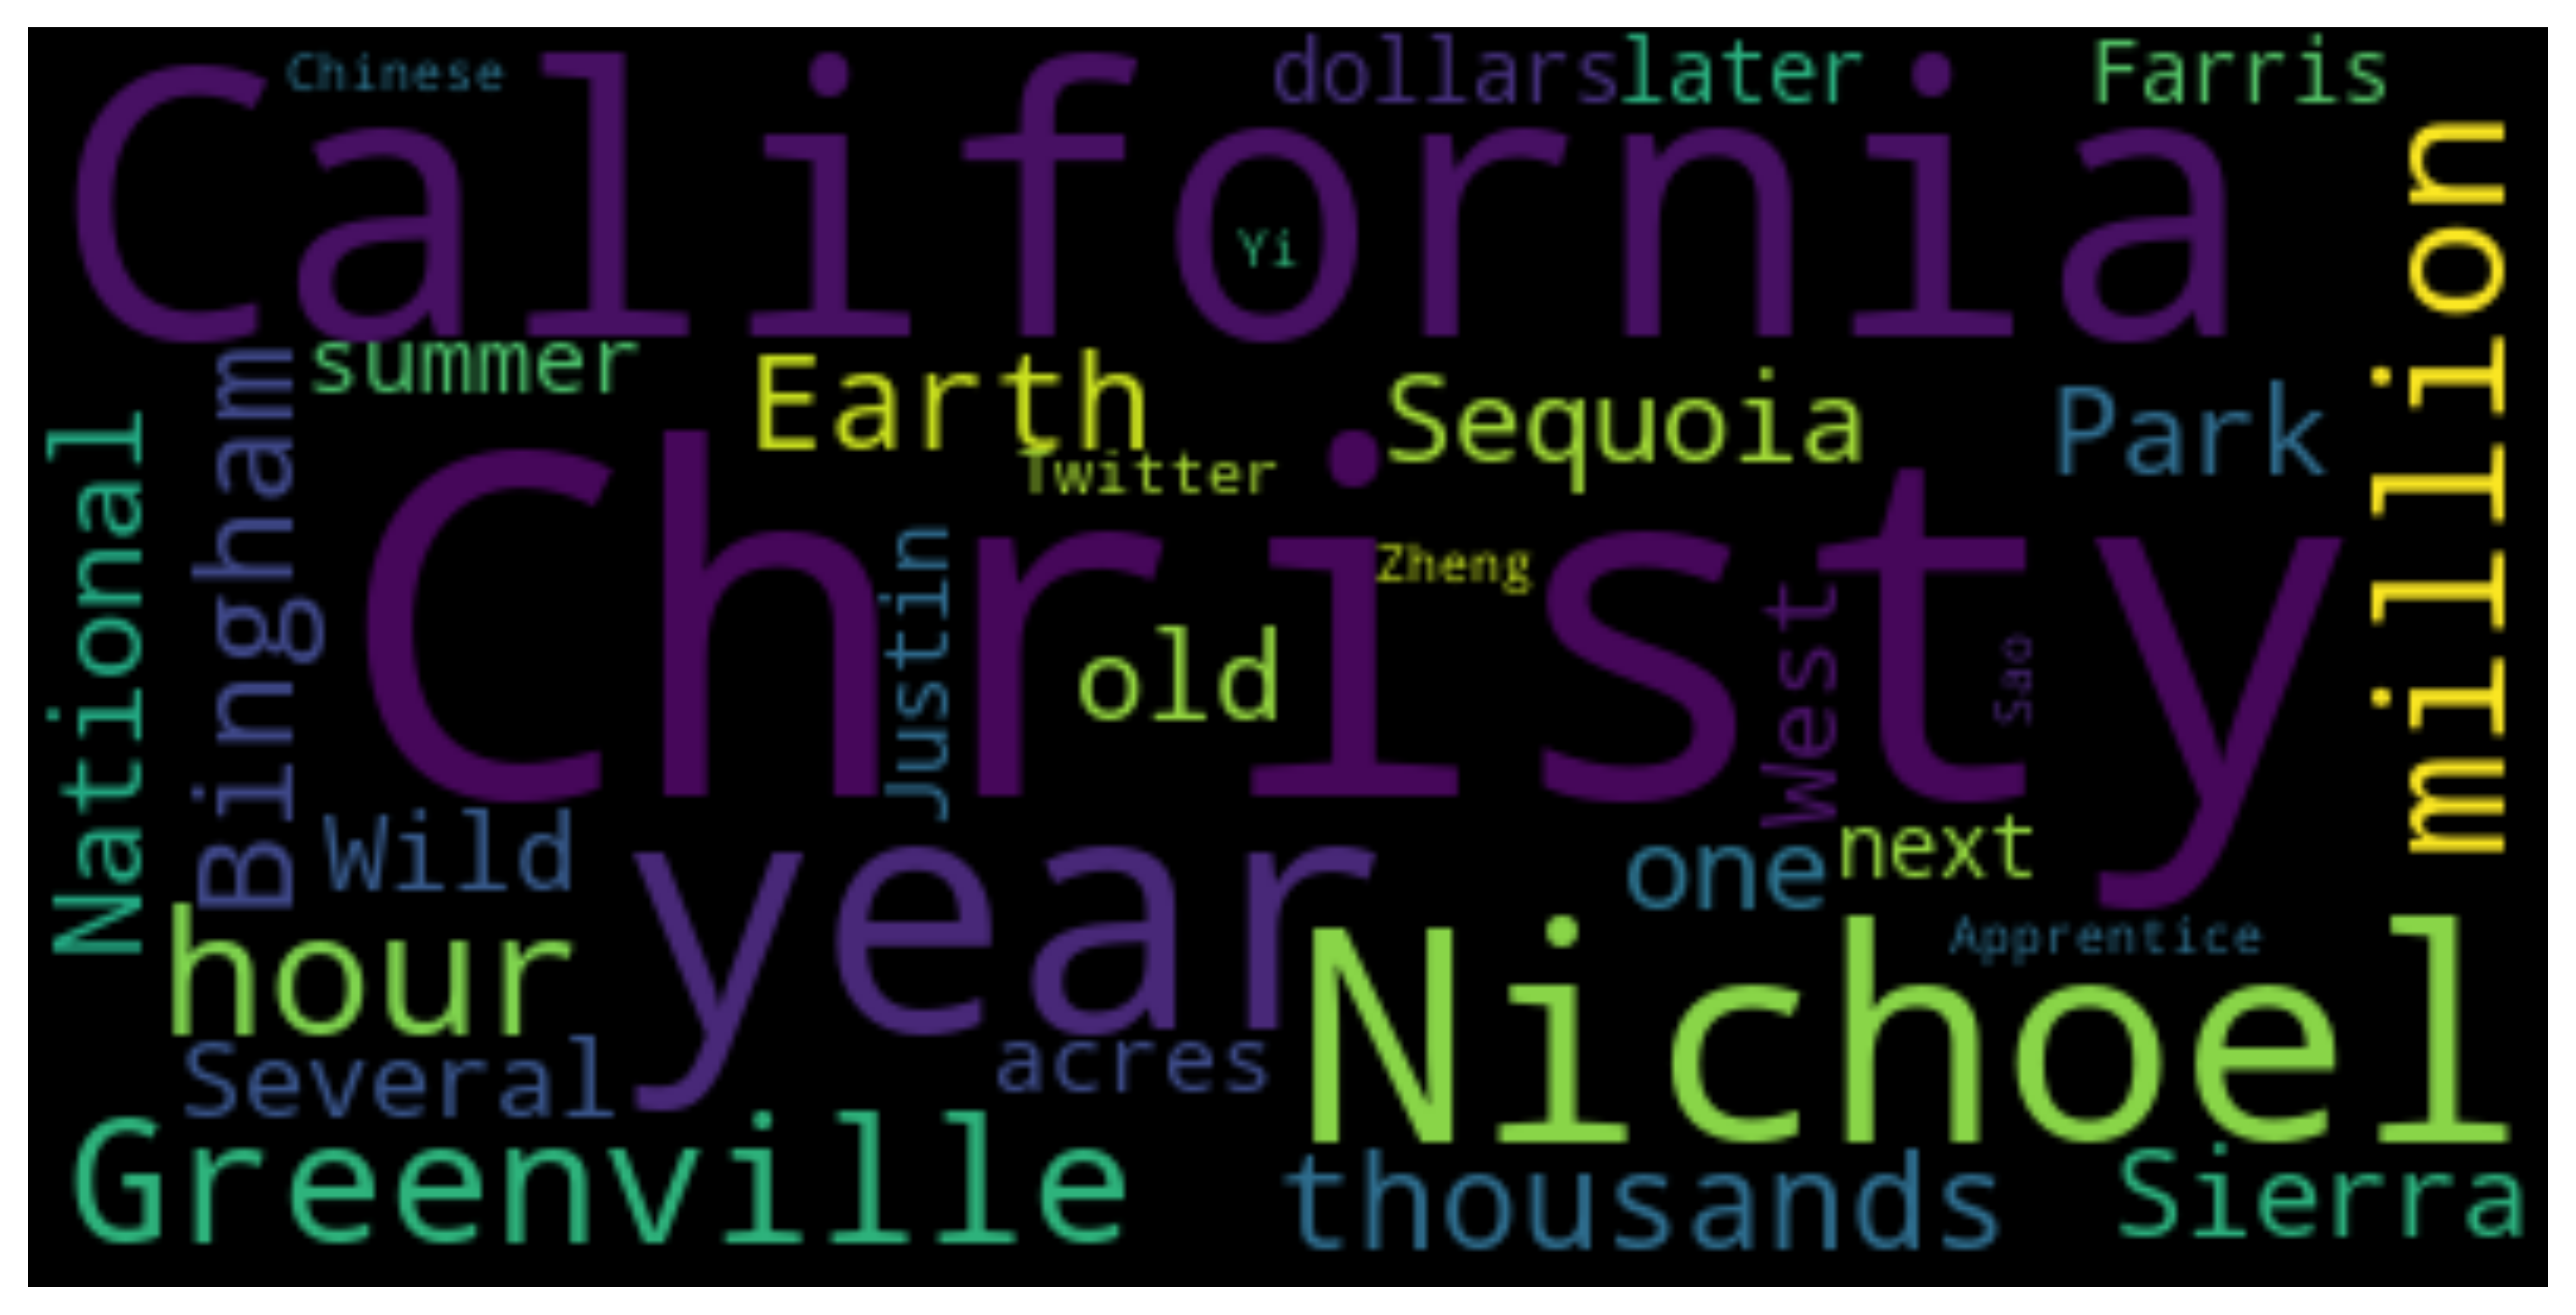

In [13]:
#Aranging named entites in a wordcloud
text = ' '.join([str(i) for i in get_Ner(str_)[0]['Entities'].to_list()])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(500)
plt.show()

In [14]:
# fetch for results using a google api.
def NE_info_fetch(named_entity) -> str :
    url = "https://google-search26.p.rapidapi.com/search"
    Ne = named_entity
    querystring = {"q":Ne,"hl":"en","tbs":"qdr:a",'as_sitesearch':'wikipedia.com'}

    headers = {
        'x-rapidapi-host': "google-search26.p.rapidapi.com",
        'x-rapidapi-key': "ea42e2dcc0msh49ecba51860383ep18d94ejsnbb0488e12e70"
        }
    try:
        response = requests.request("GET", url, headers=headers, params=querystring)
        return (response.json()['results'][0]['snippet'][:300])
    except:
        return []
    
# get summary of two phrases ( topic sentence +1 ) in which the NER figured
def sumarize(List):
    result = []
    for _ in List:
        url = "https://api.meaningcloud.com/summarization-1.0"
        querystring = {"txt":_,"of":"json",'key':'1fe6342e2cfafb085d01802a50c98e6d','limit': 10}
        response = requests.request("GET", url, params=querystring)
        result.append(response.json()['summary'])
    return result

# get summary of phrases containning a certain named enitity
def get_summary(named_entity,index) -> List[str]:
    
    text = str(Data.iloc[index]['article_content'])
    phrases = nltk.tokenize.sent_tokenize(text)
    results = []
    for _ in range(len(phrases)):
        if named_entity in phrases[_]:
            results.append(phrases[_])
    return results

In [15]:
def ner_labelise(df) -> pd.DataFrame:
    ner_data = pd.DataFrame(columns = ['Named entities'])
    for _ in tqdm(range(len(df)), desc = 'NER'):
            try:
                text = Data.iloc[_]['article_content']
                Fetch_google = lambda x : NE_info_fetch(x) 
                person_summaries = get_Ner(text)[1]['Entities'].map(lambda x : [get_summary(str(x),_), Fetch_google(str(x))])
                countries_summaries = get_Ner(text)[2]['Entities'].map(lambda x : get_summary(str(x), _))
                organisations_summaries = get_Ner(text)[3]['Entities'].map(lambda x : [get_summary(str(x), _),Fetch_google(str(x))])
                persons = get_Ner(text)[1]['Entities'].tolist() , person_summaries.tolist()
                countries = get_Ner(text)[2]['Entities'].tolist(), countries_summaries.tolist()
                organisations = get_Ner(text)[3]['Entities'], countries_summaries.tolist()
                list_ner_data =  {'persons':persons, 'countries': countries, 'organisations':organisations}
                ner_data = ner_data.append({'NE summaries' :list_ner_data},ignore_index = True)
            except:
                pass
    df = df.reset_index(drop=True)
    ner_data = ner_data.reset_index(drop=True)
    return pd.concat([df,ner_data], axis = 1)
Labelised_ner_data = ner_labelise(Data)
Labelised_ner_data.to_csv('exported_bbc_data-labelised.csv')
Labelised_ner_data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')
Labelised_ner_data.tail()

,cathegory,author,title,Publish date,article_content,images descriptions,sentiment,Named entities,NE summaries
59,Climate change,BBC News,Wind-powered net zero McDonald's opens in Market Drayton,2021-12-10,A net zero carbon McDonald's has opened in what the comp...,"['Presentational grey line', 'A woman lifting weights', ...",1.0,NaN,"{'persons': ([Simon McWhirter, Beth Hart, Market Drayton..."
60,General,BBC News,Title of article,2021-12-10,"Englandâs only Green MP, Caroline Lucas, says the UK n...","[""Queen talking to Duchess of Cornwall and the Welsh par...",1.0,NaN,"{'persons': ([Charlotte Wright, Charlotte Wright, David ..."
61,Storm Barra,BBC News,Logan Botanic Garden counts cost of Storm Barra damage,2021-12-10,A botanic garden in south west Scotland is counting the ...,"['Scots Pine', 'A woman lifting weights', 'Man smiling',...",1.0,NaN,"{'persons': ([Storm Barra, Richard Baines, Logan Botanic..."
62,Climate change,BBC News,Climate change: Four cheap ways to save energy at home,2021-12-10,Making your home more energy efficient can be costly and...,"['Short presentational grey line', 'A woman lifting weig...",1.0,NaN,"{'persons': ([James Richardson, James, Ruby Wax, Donald ..."
63,California wildfires,BBC News,Father and son arrested on suspicion of starting Caldor ...,2021-12-09,A father and son have been arrested on suspicion of sta...,"['A woman lifting weights', 'Man smiling', 'Police offic...",3.0,NaN,"{'persons': ([David Scott Smith, Travis Shane Smith, Mar..."


In [16]:
Labelised_ner_data = clean(Labelised_ner_data, True)
Labelised_ner_data.head()

,cathegory,author,title,Publish date,article_content,images descriptions,sentiment,NE summaries
0,Climate change,Nia Cerys,Snowdonia hydro schemes reach production milestone,2022-01-04,A renewable energy project in Snowdonia has produced 20 ...,"[Around the BBC iPlayer footer, Rioters storm the US Cap...",NaN,"{'persons': ([Trystan Edwards, Storm Desmond, Covid, Mr ..."
1,Climate change,BBC News,Thunderstorm alert over for south and east England,2022-01-02,"A Yellow weather alert for thunderstorms, which brought ...","[Banner saying 'Get in touch', Militants of the self-pro...",NaN,"{'persons': ([St James's Park, Roger Harrabin, Tomasz Sc..."
2,COP26,Louise Cullen,Climate change: Will 2022 be the year NI gets legislation?,2022-01-02,Northern Ireland began 2021 without climate change legis...,"[Waterworks Park, Emily Maitlis and Prince Andrew, A wom...",NaN,"{'persons': ([Clare Bailey, Edwin Poots, Brexit, Waterwo..."
3,COP26,BBC News,EU plans to label gas and nuclear energy 'green' prompt row,2022-01-02,The European Commission has proposed plans to label some...,"[A nuclear power plant in France, Rioters storm the US C...",NaN,"{'persons': ([Steffi Lemke, Robert Habeck, Zheng Yi Sao]..."
4,COP26,BBC News,Denmark to make domestic flights fossil fuel free by 2030,2022-01-02,Denmark's government has announced a goal to make domest...,"[SAS airlines planes, Rioters storm the US Capitol with ...",NaN,"{'persons': ([Mette Frederiksen, Ms Frederiksen, Zheng Y..."


In [17]:
def remove_duplicate(data) -> pd.DataFrame:
    #check for duplicates and delete them
    for _ in range(len(data)):
        if  data.duplicated().iloc[_]:
            data = data.drop(labels=str(_), axis=0) 

# III- Sentiment Analysis :
### 3.1.1 Opinion mining:

In computer science, opinion mining (also known as sentiment analysis) is the analysis of sentiments from dematerialised textual sources on large quantities of data (big data).

This process appeared at the beginning of the 2000s and has become increasingly popular due to the abundance of data from social networks, particularly those provided by Twitter. 

The objective of opinion mining is to analyse a large amount of data in order to deduce the various sentiments expressed in it. The extracted sentiments can then be used to generate statistics on the general feeling of a community.
In this part we will exctract the sentiment then labelise each one of them depending of an nlp model's result, under the name of standford coreNlp.


### 3.1.2  Standford coreNlp  :

StanfordNLP is a Python package for natural language analysis. It contains tools, which can be used in a pipeline, to convert a string containing human language text into lists of phrases and words, to generate the basic forms of these words, their parts of speech and morphological features, and to give a syntactic structure dependency parsing, using the Universal Dependencies formalism. In addition, it is able to call the CoreNLP Java package and inherit additional functionality, such as constituent parsing, coreference resolution and language model matching, as well as the part that we will undertake in this part : Sentiment analysis .

This package is built with highly accurate neural network components that allow efficient training and evaluation with your own annotated data. The modules are built on top of PyTorch. You will get much faster performance if you run this system on a machine with a GPU.

Installation and Configuration: https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a
Stanford link: https://nlp.stanford.edu/software/CRF-NER.html

In [18]:
#Analyses sentiment of an input text
def extract_sentiment(text) -> Tuple:
    java = "C:/Program Files/Java/jre1.8.0_311/bin/java.exe"
    os.environ["JAVAHOME"] = java
    annotators= 'tokenize,ssplit,pos,lemma,ner,parse,depparse,sentiment',
    # versions of Standford coreNlp
    corenlp432 =  "D:/stanford-corenlp-4.3.2/stanford-corenlp-4.3.2.jar/stanford-corenlp-4.3.2/stanford-corenlp-4.3.2.jar"
    os.environ["CORENLP_HOME"] = corenlp432
    nlp = StanfordCoreNLP('http://localhost', port=9000,timeout=30000)
    nlp_results = nlp.annotate(text,properties={
            'annotators':'sentiment,pos, ner',
            'outputFormat': 'json',
            'timeout': 50000,
            })
    json_results = json.loads(nlp_results)
    sentiment_description = json_results['sentences'][0]['sentiment']
    sentiment_value = json_results['sentences'][0]['sentimentValue']
    return sentiment_value

       Chars count
count    64.000000
mean   3187.484375
std    2362.641601
min     216.000000
25%    1378.000000
50%    3058.000000
75%    4554.750000
max    8489.000000


<AxesSubplot:>

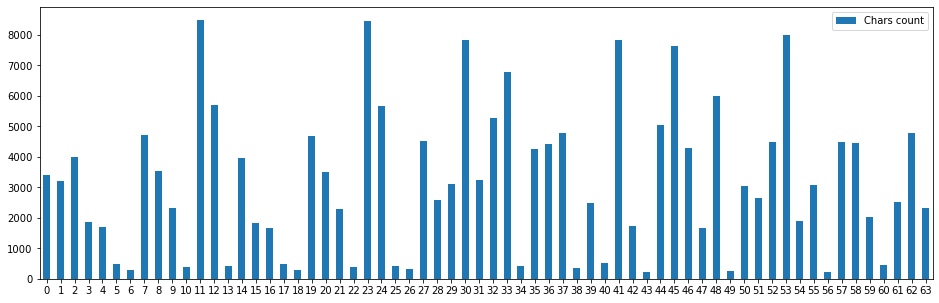

In [19]:
# A method to study the chars count distribution so to find the threshold to strip from oversized texts
# So to optimize the sentiment computing time
content = lambda index:Data.iloc[index]['article_content'] # Article sample
content_list  = [content(_) for _ in range(len(Data))]
Content_length_df = pd.DataFrame(map(len,content_list),columns = ['Chars count'])
print(Content_length_df.describe())
Content_length_df.plot.bar(y ='Chars count',figsize=(16,5), width=.5, rot=0)

In [ ]:
#labelising articles with a sentiment measuring
def labelise_articles(df) -> pd.DataFrame:
    sentiment_data = pd.DataFrame(columns = ['sentiment'])
    for _ in tqdm(range(len(df)), desc = 'Analysing sentiment of articles'):
        text = Data.iloc[_]['article_content'].replace('.',',')+','.join(Data.iloc[_]['images descriptions'])
        if len(text)> 5000: #threshold
            text = text[:-len(text) // 3]
        try :
            sentiment_value = extract_sentiment(text)
        except:
            #sometimes, corenlp fails to measure the sentiment
            sentiment_value = rd.randint(1,3)
        sentiment_data = sentiment_data.append({'sentiment':sentiment_value},ignore_index = True)
    return pd.concat([df,sentiment_data], axis = 1)
Labelised_data = labelise_articles(Data)
Labelised_data.to_csv('exported_bbc_data-labelised.csv')
Labelised_data

In [ ]:
Labelised_data.to_csv('exported_bbc_data-labelised.csv')
Labelised_data.to_excel('exported_bbc_data-labelised.xlsx')
Labelised_data.to_excel('dash_web_app/exported_bbc_data-labelised.xlsx')


In [ ]:
labelised_data  = pd.read_csv('exported_bbc_data-labelised.csv')[['cathegory','title','Publish date', 'images descriptions','sentiment','Named entities']]
labelised_data.head()

In [ ]:
def extract_node()-> List:
    result = []
    for _ in tqdm(range(len(Labelised_ner_data))):
            try:
                if Labelised_ner_data['NE summaries'].iloc[_]['persons'] :
                    persons = Labelised_ner_data['NE summaries'].iloc[_]['persons'][0]
                    result.append(persons)
            except:
                pass
    return result
extract_node()
    

In [4]:
text = """The European Commission has proposed plans to label some gas and nuclear power as green, prompting criticism from Germany.
                    The proposal argues that gas and nuclear are key to helping transition to cleaner power.
                    But Germany's environment minister called the plan 'absolutely wrong'."""

In [111]:
import re
import pandas as pd
import spacy
from spacy import displacy
import pandas as pd
Data = pd.read_excel('exported_bbc_data-labelised.xlsx')

nlp = spacy.load('en_core_web_sm')
index = 14
str_ = str(Data.iloc[index]['article_content']) # Article samplefrom spacy.matcher import Matcher 

from spacy.tokens import Span 
def construct_kg(str_): 
    sent = nltk.tokenize.sent_tokenize(str_)
    def get_entities(sent):
        ## chunk 1
        ent1 = ""
        ent2 = ""

        prv_tok_dep = ""    # dependency tag of previous token in the sentence
        prv_tok_text = ""   # previous token in the sentence

        prefix = ""
        modifier = ""

          #############################################################
        for tok in nlp(sent):
            ## chunk 2
            # if token is a punctuation mark then move on to the next token
            if tok.dep_ != "punct":
              # check: token is a compound word or not
                if tok.dep_ == "compound":
                    prefix = tok.text
                    # if the previous word was also a 'compound' then add the current word to it
                    if prv_tok_dep == "compound":
                        prefix = prv_tok_text + " "+ tok.text

              # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                    modifier = tok.text
                    # if the previous word was also a 'compound' then add the current word to it
                    if prv_tok_dep == "compound":
                        modifier = prv_tok_text + " "+ tok.text
              ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

              ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

              ## chunk 5  
              # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

        return [ent1.strip(), ent2.strip()]
    def get_relation(sent):
        doc = nlp(sent)

      # Matcher class object 
        matcher = Matcher(nlp.vocab)

      #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 

        matcher.add("matching_1", [pattern], on_match=None) 

        matches = matcher(doc)
        k = len(matches) - 1

        span = doc[matches[k][1]:matches[k][2]] 

        return(span.text)
    entity_pairs = [get_entities(_) for _ in sent ] 
    source = [i[0] for i in entity_pairs ]
    # extract object
    target = [i[1] for i in entity_pairs]
    relations = [get_relation(_) for _ in sent]
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
    return kg_df
construct_kg(str_)

,source,target,edge
0,coldest US state,warm December spell,recorded
1,Temperatures,previous high,soared to
2,,elsewhere Alaska lows,plunging
3,south eastern temperatures,past Christmas century,dropped to
4,hard cement,roads,prompted
5,air,more moist,say warm
6,rain storms,coastal areas,meant heavy
7,rain,widespread power failures,followed by torrential
8,them,Alaska Transportation,warned
9,extremely it,road surface,is


In [112]:
list_c = [get_Ner(str_)[_].Entities.values.tolist() for _ in [1,2,3]]
def flatten(lst):
    """Flatten a list using generators comprehensions."""
    Ne_gen = (item for sublist in lst for item in sublist)
    return [_ for _ in Ne_gen]

Ne_list =flatten(list_c)
print(Ne_list)
kg_df = construct_kg(str_)
kg_df.head()
# checkpoint, add extend to fetch the list of all words tokenisation from named entities lists

[Rick Thoman, Mr Thoman, Mr Thoman, Ruby Wax, Donald Trump, US, Alaska, Kodiak, Alaska, Ketchikan, Hawaii, Alaska, Ice, Icemageddon, the Alaska Department of Transportation and Public Facilities, the Alaska Center for Climate Assessment and Policy, BBC, Delta Junction, Fairbanks, Thoman, BBC]


,source,target,edge
0,coldest US state,warm December spell,recorded
1,Temperatures,previous high,soared to
2,,elsewhere Alaska lows,plunging
3,south eastern temperatures,past Christmas century,dropped to
4,hard cement,roads,prompted


In [113]:
kg_df[['source','target']].to_csv('sample_network.txt', header=None, index=None, sep=' ', mode='a')
kg_df.to_csv('sample_network.csv', header=None, index=None, sep=';', mode='a')

In [102]:
#keep only named entities, try to select the nodes that are named entities in the prev funct
named_entities_list = Named_entities_list(Data.iloc[9]['article_content'])
def is_value_df(series, List_values):
    result = []
    for _ in series:
        if _['source'] in ' '.join(List_values):
            result.append = True 
    return result


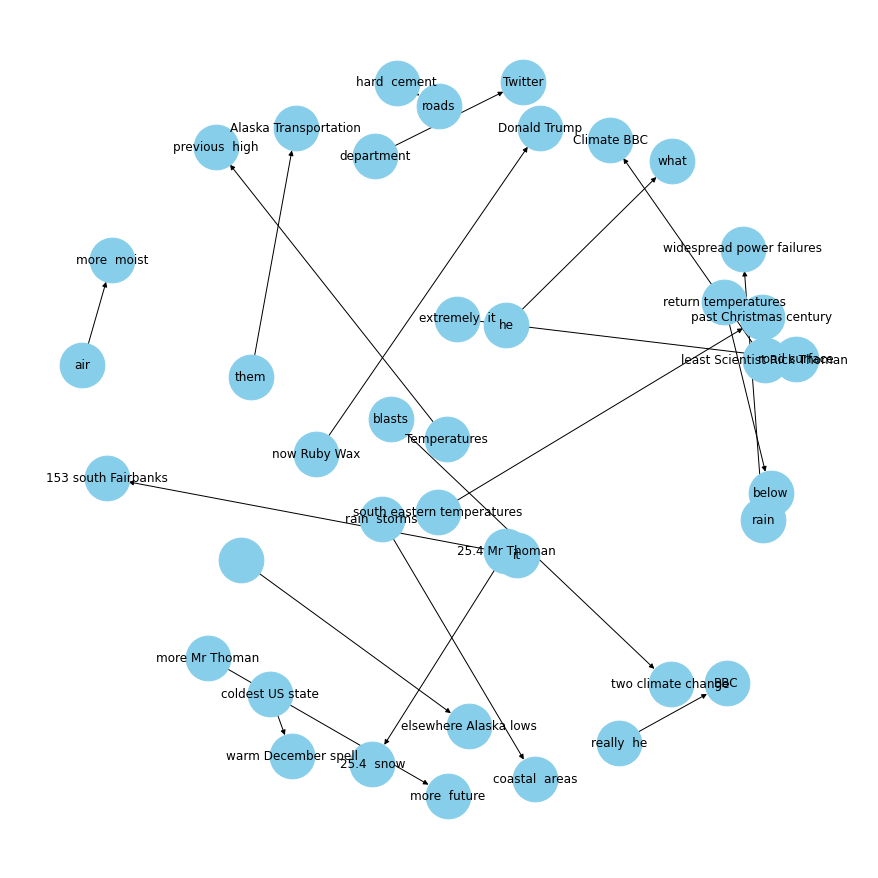

In [116]:
plt.figure(figsize=(12,12))
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

pos = nx.spring_layout(G, k =.8) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000 ,edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [79]:
def git_update():
    !git commit -am "Minor changes"
    !git push
    print('changes updated succesfully on git.')
git_update()

[main a3a88a7] Minor changes

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
The file will have its original line endings in your working directory



 4 files changed, 8331 insertions(+), 9684 deletions(-)
 rewrite .ipynb_checkpoints/main-checkpoint.ipynb (69%)
 rewrite main.ipynb (69%)
changes updated succesfully on git.


To https://github.com/oussamasmihrou/bbcguardian.git
   d412ff9..a3a88a7  main -> main
